<a href="https://colab.research.google.com/github/bgkim/Byungki-Kim/blob/master/opencv_emotion_Colab01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow keras opencv-python numpy

In [0]:
!if not exist "./files" mkdir files, Colab에서는 구글 드라이브에 연결하여 사용  
# Download Face detection XML 
!curl -L -o /content/gdrive/My Drive/haarcascade_frontalface_default.xml https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
# Download emotion trained data
!curl -L -o /content/gdrive/My Drive/emotion_model.hdf5 https://mechasolution.vn/source/blog/AI-tutorial/Emotion_Recognition/emotion_model.hdf5

In [0]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

#사용시에는 "/content/gdrive/My Drive/" 로 패스 설정

<IPython.core.display.Javascript object>

Saved to photo.jpg


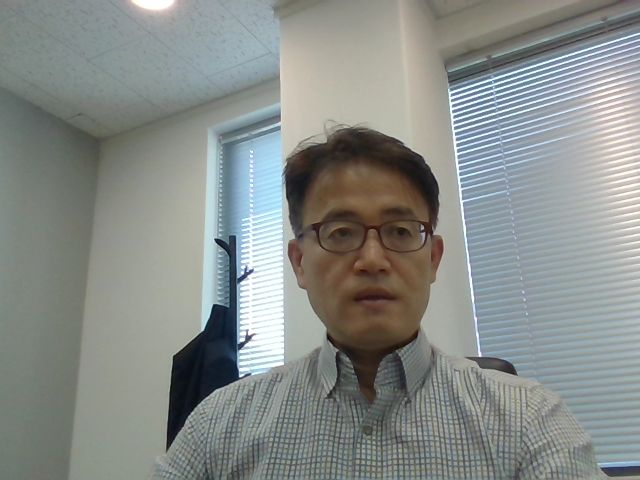

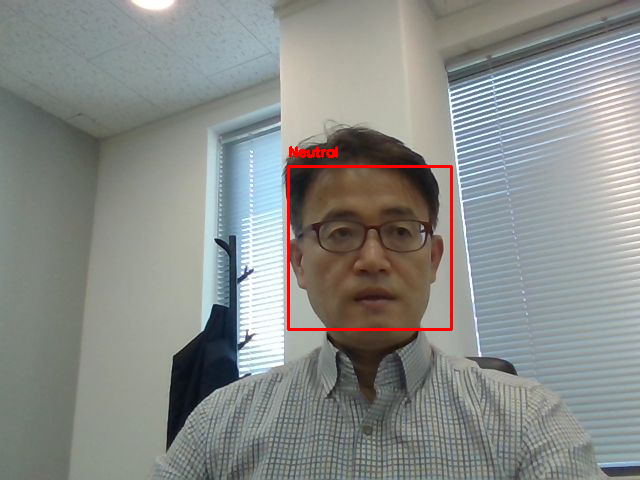

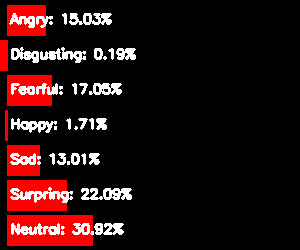

In [45]:
import cv2
import numpy as np   
from keras.preprocessing.image import img_to_array
from keras.models import load_model

#Colab에서 사용
from google.colab.patches import cv2_imshow

# Face detection XML load and trained model loading
face_detection = cv2.CascadeClassifier('/content/gdrive/My Drive/data/haarcascade_frontalface_default.xml')
emotion_classifier = load_model('/content/gdrive/My Drive/data/emotion_model.hdf5', compile=False)
EMOTIONS = ["Angry" ,"Disgusting","Fearful", "Happy", "Sad", "Surpring", "Neutral"]

# Video capture using webcam, Local에서 실행시 사용
# camera = cv2.VideoCapture(0)
# Colabl에서는 아래 코드 사용 
# WebCam 이미지를 Google Drive에 저장 
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
#요기까지 Colab 

while True:
    # Capture image from camera, Local에서 실행시 사용
    #ret, frame = camera.read()
    # Colab에서는 아래 코드 사용 
    frame = cv2.imread(filename, cv2.IMREAD_COLOR)

    # Convert color to gray scale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Face detection in frame
    faces = face_detection.detectMultiScale(gray,
                                            scaleFactor=1.1,
                                            minNeighbors=5,
                                            minSize=(30,30))
    
    # Create empty image
    canvas = np.zeros((250, 300, 3), dtype="uint8")
    
    # Perform emotion recognition only when face is detected
    if len(faces) > 0:
        # For the largest image
        face = sorted(faces, reverse=True, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
        (fX, fY, fW, fH) = face
        # Resize the image to 48x48 for neural network
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (48, 48))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        # Emotion predict
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
        
        # Assign labeling
        cv2.putText(frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.rectangle(frame, (fX, fY), (fX + fW, fY + fH), (0, 0, 255), 2)
 
        # Label printing
        for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
            text = "{}: {:.2f}%".format(emotion, prob * 100)    
            w = int(prob * 300)
            cv2.rectangle(canvas, (7, (i * 35) + 5), (w, (i * 35) + 35), (0, 0, 255), -1)
            cv2.putText(canvas, text, (10, (i * 35) + 23), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 2)

    # Open two windows
    ## Display image ("Emotion Recognition")
    ## Display probabilities of emotion
    #cv2.imshow('Emotion Recognition', frame)
    #cv2.imshow("Probabilities", canvas)

    # Colab에서 사용시에 ...
    cv2_imshow(frame)
    cv2_imshow(canvas)
    break
    
    # q to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clear program and close windows
#camera.release()
cv2.destroyAllWindows()

In [0]:
# Colab에서 WebCam 사용하여 이미지 구하기 
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
# WebCam 이미지를 Google Drive에 저장 
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))